In [77]:
import pandas as pd
import numpy as np
import matplotlib_venn as mv

# deux imports
#  1 : du df créé par contrib_from_csv.py, 
#  2 : du df créé par contrib_from_original.py

df_original = pd.read_csv("contrib_from_original.csv", sep = ",", dtype= str)
df_processed = pd.read_csv("contrib_from_csv.csv", sep = ",", dtype= str)

#  affiche la totalité du dataframe (utiliser seulement pour les df de petite taille)

def print_full(df):
    import pandas as pd
    pd.set_option('display.max_rows', len(df))
    print(df)
    pd.reset_option('display.max_rows')

print(df_original.isna().any()) # aucune NA dans l'original
print(df_processed.isna().any()) # les NA de codes postal et type graphie ont été résolues

# pour afficher toutes les lignes contenant des NaN
print_full(df_processed[df_processed.isna().any(axis=1)])


Unnamed: 0           False
filename             False
nb_of_file           False
xml                  False
categorie_region     False
info_communes        False
Catégorie            False
Code postal          False
Date de réception    False
Code INSEE           False
Type Graphie TT      False
Numéro d'id_cc       False
dtype: bool
Catégorie                    False
Date de réception            False
Code postal                  False
Code INSEE                   False
Numéro d'ordre arbitraire    False
Type Graphie TT              False
Numéro de page               False
Numéro séquentiel            False
Contribution                 False
joined_id                    False
dtype: bool
Empty DataFrame
Columns: [Catégorie, Date de réception, Code postal, Code INSEE, Numéro d'ordre arbitraire, Type Graphie TT, Numéro de page, Numéro séquentiel, Contribution, joined_id]
Index: []


In [78]:
# vérifier qu'il n'y a que les contributions viennent toutes des carnets citoyens

print(pd.unique(df_processed["Catégorie"]))
print(pd.unique(df_original["Catégorie"]))

['CC']
['CC']


In [65]:
# testé : il n'y a pas de DUPLICATE

# AFFICHER les types d'element des df et leur taille:

# print("XML :\n", df_original.sample(3))
# print ("xml", df_original.dtypes)
# print("XML shape :\n", df_original.shape)

# print("csv", df_processed.dtypes)
# print("CSV shape :\n",df_processed.shape)
# print("CSV :\n", df_processed.sample(3))

# pour trouver toutes les contribution à partir d'un seul ID de CC (un seul carnet) :

print(df_processed.loc[df_processed["joined_id"] == "CC_70000_190225_70163_MD_06225"])

       Catégorie Date de réception Code postal Code INSEE  \
134622        CC            190225       70000      70163   
134623        CC            190225       70000      70163   
134624        CC            190225       70000      70163   
134625        CC            190225       70000      70163   
134626        CC            190225       70000      70163   
134627        CC            190225       70000      70163   
134628        CC            190225       70000      70163   
134629        CC            190225       70000      70163   
134630        CC            190225       70000      70163   
134631        CC            190225       70000      70163   
134632        CC            190225       70000      70163   
134633        CC            190225       70000      70163   
134634        CC            190225       70000      70163   
134635        CC            190225       70000      70163   
134636        CC            190225       70000      70163   
134637        CC        

In [66]:

# compte le nombre de contributions pour chaque id de carnet, 
# pour avoir le même niveau que le df des originaux AN

group1 = pd.DataFrame({'count' : df_processed.groupby( ["joined_id"] ).size()}).reset_index()

print(df_processed.sample(2))

      Catégorie Date de réception Code postal Code INSEE  \
84005        CC            190322       44700      44114   
58878        CC            190315       04260      04006   

      Numéro d'ordre arbitraire Type Graphie TT Numéro de page  \
84005                     19933              MD             25   
58878                     17523               M             27   

      Numéro séquentiel                                       Contribution  \
84005                20  Travailler avec force et détermination en util...   
58878                11  Je pense que ne devraient faire l' objet d' in...   

                            joined_id  
84005  CC_44700_190322_44114_MD_19933  
58878  CC_04260_190315_04006_MD_17523  


In [67]:
# renommer les noms de colonnes pour pv merge

df_original = df_original.rename(columns={"info_communes": "joined_id"})
df_original = df_original.rename(columns={"Numéro d'id_cc": "Numéro d'ordre arbitraire"})


# merge sur les noms de dossiers

mergedStuff = pd.merge(df_original, group1, left_on=["joined_id"], 
               right_on=["joined_id"],
            #    on=['joined_id'], 
                how='outer', indicator=True)

# original qui n'existent pas dans processed (noms de dossiers)

left_only = mergedStuff.loc[mergedStuff["_merge"] == "left_only"]


# processed qui n'existe pas original (noms de dossiers)

right_only = mergedStuff.loc[mergedStuff["_merge"] == "right_only"]

# nombre de différences pour les deux

print("left_only.shape", left_only.shape)
print("right_only.shape", right_only.shape)

left_only.shape (855, 14)
right_only.shape (1317, 14)


In [68]:
# cree une colonne DEPARTEMENTS pour les datas processed en prenant les deux premiers chiffres du code postal

df_processed["departement"] = df_processed["Code postal"].astype(str).str[:2]


# pour les communes qui ne partagent pas leur n° de département avec leur insee, j'utilise le même classement que l'original AN (code postal > code insee). vu dans le test suivant :
# print(df_original.loc[df_original["Code INSEE"] == '04058'])
# print(df_original.loc[df_original["Code postal"] == '05110'])

# cree une colonne departement pour les datas AN à partir du code postal aussi

df_original["departement"] = df_original["Code postal"].astype(str).str[:2]

print(df_original.loc[df_original["departement"] == "78"])

Empty DataFrame
Columns: [Unnamed: 0, filename, nb_of_file, xml, categorie_region, joined_id, Catégorie, Code postal, Date de réception, Code INSEE, Type Graphie TT, Numéro d'ordre arbitraire, departement]
Index: []


In [69]:
# choix de la variable à observer :
# un indice pour choisir la variable à tester (numéro arbitraire -aka id carnet- ne s'applique qu'aux comparaison inter corpus)

info_recherche = ["Code INSEE", "departement", "Numéro d'ordre arbitraire"]
noms = ["Communes", "Département", "Carnets (numéro d'ordre arbitraire)"]
choix = 1


# compte le nombre de contributions pour chaque code

processed_groupdf = df_processed.groupby([info_recherche[choix]]).size().reset_index()
print("GROUPBY processed SAMPLE seulement\n",processed_groupdf.sample(1))


# merge outer entre processed et original selon l'indice choix (commune ou dpt ou id carnet)

uniques_original = pd.DataFrame(pd.unique(df_original[info_recherche[choix]]), columns=[info_recherche[choix]]).reset_index(drop=True)
print("uniques_original.shape : ",uniques_original.shape)
uniques_processed = pd.DataFrame(pd.unique(df_processed[info_recherche[choix]]), columns=[info_recherche[choix]]).reset_index(drop = True)
print("uniques_processed.shape : ",uniques_processed.shape)
merge_df = pd.merge(uniques_original, uniques_processed, on=[info_recherche[choix]], how='outer', indicator='source')
# NOTE : ceux la peuvent être comparer entre eux car ils sont le même type d'objet

# fait deux merge, un sur le outer left et un sur le outer right pour récup les codes exclus chacuns par l'autre
# processed vs. original + ecrit les listes exclues de chacuns dans un csv

dict_of_df = {}
for i in [0,1] :
    mer = ["left_only", "right_only"]
    nam = ["original", "derivé csv"]
    result = merge_df[merge_df.source.eq(mer[i])].drop('source', axis=1)
    print("MERGE result shape : "+nam[i], result.shape)
    print("MERGE result sample 10 : "+nam[i], "\n")

    result.to_csv(noms[choix]+"_seulement_dans_"+nam[i]+"_pour_original_vs_processed.csv", columns=[info_recherche[choix]], index = False)


GROUPBY processed SAMPLE seulement
    departement     0
88          88  1587
uniques_original.shape :  (96, 1)
uniques_processed.shape :  (99, 1)
MERGE result shape : original (0, 1)
MERGE result sample 10 : original 

MERGE result shape : derivé csv (3, 1)
MERGE result sample 10 : derivé csv 



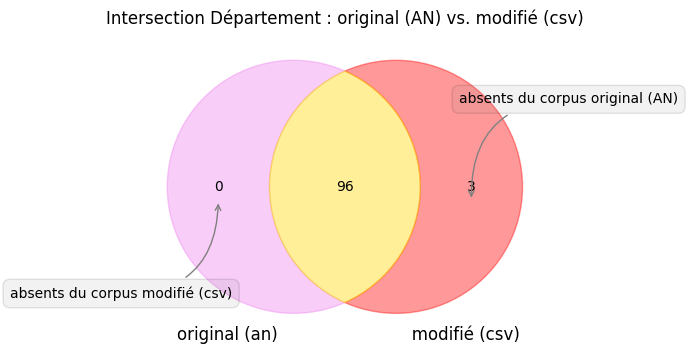

In [70]:
# affiche les intersections - exclusions du merge original vs. processed
# les montre (venn diagram) et les sauvegarde

from matplotlib import pyplot as plt

inner_merged = pd.merge(uniques_original, uniques_processed, on=[info_recherche[choix]], how='inner', indicator='source')

# define size of figure

plt.figure(figsize=(8,4))

v = mv.venn2_unweighted([set(list(df_original[info_recherche[choix]])), set(list(df_processed[info_recherche[choix]]))], set_labels= ("original (an)   ", "   modifié (csv)"))
# mêmes resultats avec :
# v = mv.venn2([set(list(uniques_original[info_recherche[choix]])), set(list(uniques_processed[info_recherche[choix]]))], set_labels= ("original (an)   ", "   modifié (csv)"))

# choose color

v.get_patch_by_id('10').set_color('violet')
v.get_patch_by_id('01').set_color('red')
v.get_patch_by_id('11').set_color('gold')


# choose title

plt.title("Intersection "+noms[choix]+" : original (AN) vs. modifié (csv)")

# add some texts

plt.annotate('absents du corpus modifié (csv)', xy=v.get_label_by_id('10').get_position() - np.array([0, 0.05]), xytext=(-70,-70),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.annotate('absents du corpus original (AN)', xy=v.get_label_by_id('01').get_position() - np.array([0, 0.05]), xytext=(70,70),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
# plt.show(v)
plt.savefig("original_vs_modifie_"+noms[choix]+".png", format = "png", dpi = 800)



In [71]:
# comparaison insee stats vs. corpus processed stats

# retrieve insee datas from insee csv
# retrieve dept or communes values only, from insee df into a df and rename the column

if choix == 0 :
    df_communes = pd.read_csv("cog_ensemble_2019_csv/communes-01012019.csv", sep = ",")
    df_insee = pd.Series(df_communes["com"], name=info_recherche[choix]).reset_index(drop = True)

else :
    df_departement = pd.read_csv("cog_ensemble_2019_csv/departement2019.csv", sep = ",")
    df_insee = pd.Series(df_departement["dep"], name=info_recherche[choix]).reset_index(drop = True)


# create a df with departement only from the processed df (csv), sort them -> they now can be used on compare with insee sheets (bc same objects types I guessed)

processed_compare_df = pd.unique(df_processed[info_recherche[choix]])
processed_compare_df = pd.Series(np.sort(processed_compare_df), name=info_recherche[choix], dtype=str).reset_index(drop = True)
shape_processed = processed_compare_df.shape

# merge the two

merged_departement = pd.merge(df_insee.astype(str), processed_compare_df.astype(str), how='outer', indicator='source')
print(uniques_processed)

# compare the two series and save the exclusion of each
for i in [0,1] :
    mer = ["left_only", "right_only"]
    nam = ["insee", "processed"]
    result = merged_departement[merged_departement.source.eq(mer[i])].drop('source', axis=1)
    print(nam[i],"\n",  result)
    print(nam[i]," shape\n",  result.shape)

    result.to_csv(noms[choix]+"_seulement_dans_"+nam[i]+"_pour_insee_vs_processed.csv", columns=[info_recherche[choix]], index = False)


   departement
0           00
1           10
2           17
3           14
4           19
..         ...
94          99
95          40
96          61
97          84
98          87

[99 rows x 1 columns]
insee 
     departement
28           2A
29           2B
96          971
97          972
98          973
99          974
100         976
insee  shape
 (7, 1)
processed 
     departement
101          00
102          20
103          97
104          98
105          99
processed  shape
 (5, 1)


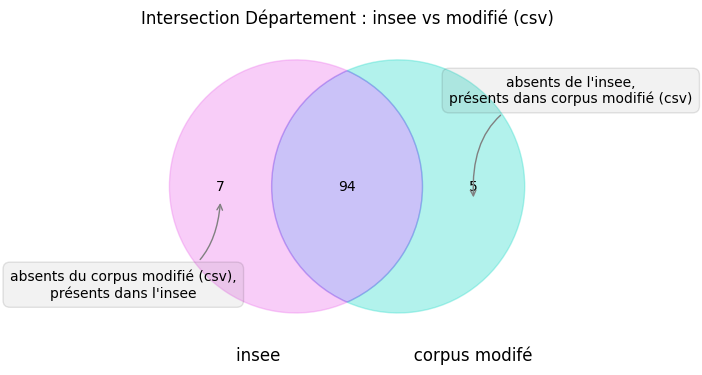

In [72]:
# show inclusion exclusion with venn diagram for insee vs. processed

plt.figure(figsize=(8,4))
v = mv.venn2_unweighted([set(list(df_insee)), set(list(processed_compare_df))], set_labels= ("\ninsee   ", "\n   corpus modifé"))

v.get_patch_by_id('10').set_color('violet')
v.get_patch_by_id('01').set_color('turquoise')
v.get_patch_by_id('11').set_color('mediumslateblue')


plt.title("Intersection "+noms[choix]+" : insee vs modifié (csv)")
plt.annotate('absents du corpus modifié (csv),\nprésents dans l\'insee', xy=v.get_label_by_id('10').get_position() - np.array([0, 0.05]), xytext=(-70,-70),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.annotate('absents de l\'insee,\nprésents dans corpus modifié (csv)', xy=v.get_label_by_id('01').get_position() - np.array([0, 0.05]), xytext=(70,70),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))

plt.savefig("insee_vs_modifie_"+noms[choix]+".png", format = "png", dpi = 1000)

#  différences des départements
#  2A et 2B = la corse 20
#  97 = les outrmer tous ensemble
#  98 et 99 = ? colonies qui n'existent plus, aka l'algérie ou :
#  987 = polynésie française(?) "communauté autonome rattachée à la france"
#  986 = wallis et futuna
#  984 = territoires australes
#  98000 = monaco (???)
#  988 = nouvelle calédonie

<class 'pandas.core.series.Series'>
insee 
     departement
28           2A
29           2B
76           76
77           77
78           78
96          971
97          972
98          973
99          974
100         976
original 
     departement
101          00
102          20
103          97
104          98
105          99


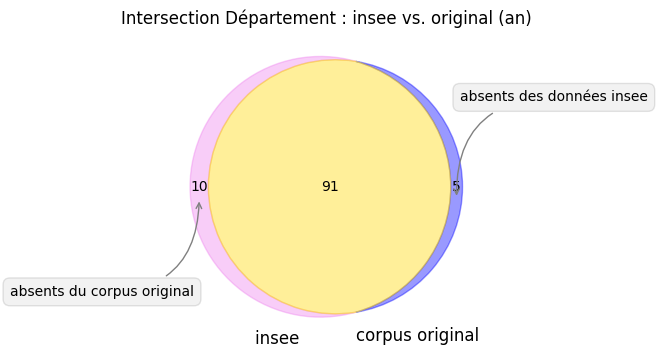

In [73]:
# comparaison insee stats vs. corpus original de l'AN stats

compare_original = pd.unique(df_original[info_recherche[choix]])
compare_original = pd.Series(np.sort(compare_original), name=info_recherche[choix], dtype=str).reset_index(drop = True)
print(type(compare_original))
original_shape = compare_original.shape
insee_shape = df_insee.shape

# merge the two

merged_departement = pd.merge(df_insee.astype(str), compare_original.astype(str), how='outer', indicator='source')

# compare the two series and save them
# "Can only compare identically-labeled Series objects" : serie .compare() doit avoir le meme nombre rows

for i in [0,1] :
    mer = ["left_only", "right_only"]
    nam = ["insee", "original"]
    result = merged_departement[merged_departement.source.eq(mer[i])].drop('source', axis=1)
    print(nam[i],"\n",  result)

    result.to_csv(noms[choix]+"_seulement_dans_"+nam[i]+"_pour_insee_vs_original.csv", columns=[info_recherche[choix]], index = False)


# show the inclusion - exclusion with venn diagram

plt.figure(figsize=(8,4))

v = mv.venn2([set(list(df_insee)), set(list(compare_original))], set_labels= ("insee    ", "    corpus original"))
v.get_patch_by_id('10').set_color('violet')
v.get_patch_by_id('11').set_color('gold')

v.get_patch_by_id('01').set_color('blue')
# v.get_patch_by_id('11').set_color('pink')
plt.title("Intersection "+noms[choix]+" : insee vs. original (an)")
plt.annotate('absents du corpus original', xy=v.get_label_by_id('10').get_position() - np.array([0, 0.05]), xytext=(-70,-70),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.annotate('absents des données insee', xy=v.get_label_by_id('01').get_position() - np.array([0, 0.05]), xytext=(70,70),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.savefig("insee_vs_original_"+noms[choix]+".png", format = "png", dpi = 1000)
plt.show(v)

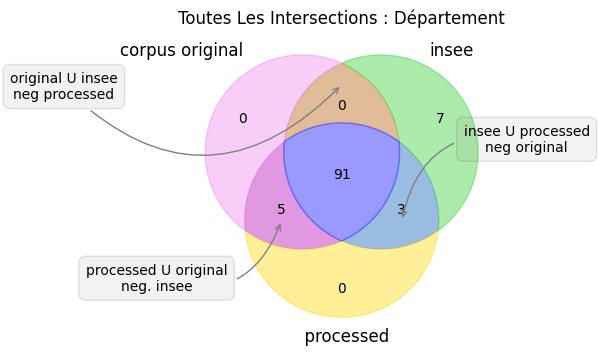

In [74]:
# diagram of the two corpus and the insee stats
# compare the three df :
# processed_compare_df
# compare_original
# df_insee

plt.figure(figsize=(8,4))

v3 = mv.venn3_unweighted([set(list(compare_original)), set(list(df_insee)), set(list(processed_compare_df))], set_labels= ("corpus original  ","insee","  processed" ))
# index of each part, for design (100, 010, 110, 001, 101, 011, 111)

# define colors

v3.get_patch_by_id('100').set_color('violet')
v3.get_patch_by_id('001').set_color('gold')

v3.get_patch_by_id('111').set_color('blue')
v3.get_patch_by_id('010').set_color('limegreen')
# v3.get_patch_by_id('110').set_color('darkgreen')

# title

plt.title("Toutes Les Intersections : "+noms[choix])

# add some text for intersections

plt.annotate('original U insee\nneg processed', xy=v3.get_label_by_id('110').get_position() - np.array([0, -0.09]), xytext=(-200,-10),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.annotate('insee U processed\nneg original', xy=v3.get_label_by_id('011').get_position() - np.array([0, 0.05]), xytext=(90,50),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.annotate('processed U original\nneg. insee', xy=v3.get_label_by_id('101').get_position() - np.array([0, 0.05]), xytext=(-90,-50),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))

# plt.show()

plt.savefig(noms[choix]+"_all.png", format = "png", dpi = 1000)



<Figure size 800x200 with 0 Axes>

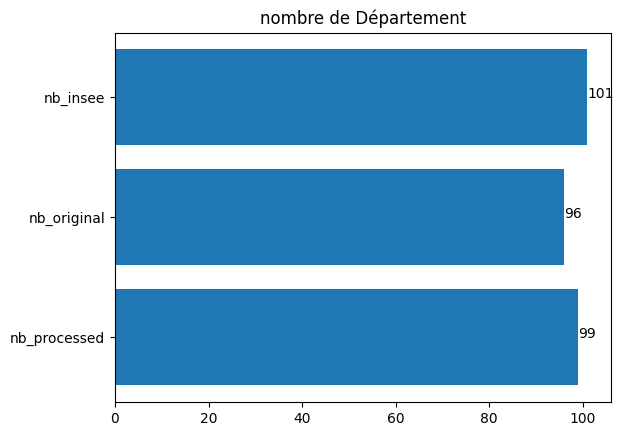

In [75]:
# show the number of <dpt or communes> for 1/insee, 2/original, 3/processed
#  and save

values = np.array([shape_processed[0], original_shape[0], insee_shape[0]])
# values = np.array([shape_processed[0], original_shape[0]])

names = ("nb_processed", "nb_original", "nb_insee")
# names = ("nb_processed", "nb_original")

plt.figure(figsize=(8,2))
fig, ax = plt.subplots()
plt.barh(names, values)
for index, value in enumerate(values):
    plt.text(value, index,
             str(value))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('nombre de '+noms[choix])
plt.savefig(noms[choix]+"_data.png", format = "png", dpi = 1000)
plt.show()